<a href="https://colab.research.google.com/github/ericburdett/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [340]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving pcc_temple.jpeg to pcc_temple (6).jpeg

Upload Style Image


Saving texture3.jfif to texture3 (1).jfif
Content Path: <_io.BytesIO object at 0x7f0b126d5570>
Style Path: <_io.BytesIO object at 0x7f0b19d66410>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [343]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
style_layers = [vgg_names.index("conv1_1"), vgg_names.index("conv2_1"), vgg_names.index("conv3_1"), vgg_names.index("conv4_1"), vgg_names.index("conv5_1")]
content_layers = [vgg_names.index("conv5_3")]
all_layers = [vgg_names.index("conv1_1"), vgg_names.index("conv2_1"), vgg_names.index("conv3_1"), vgg_names.index("conv4_1"), vgg_names.index("conv5_1"), vgg_names.index("conv5_3")]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
style_vgg = VGGIntermediate(style_layers).cuda()
content_vgg = VGGIntermediate(content_layers).cuda()
vgg = VGGIntermediate(all_layers).cuda()

# Cache the outputs of the content and style layers for their respective images
style_out = style_vgg(style_image)
content_out = content_vgg(content_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**
* Display the style tensor and content tensor transformed back to an image

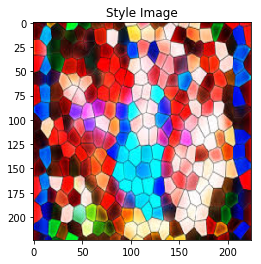

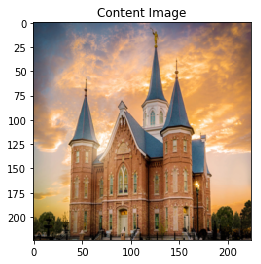

In [344]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

def imshow(tensors, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image    
    num = len(tensors)
    f, axs = plt.subplots(1,num, figsize=(8*num, 8))
    
    for i in range(len(tensors)):
        image = tensors[i].cpu().clone()  # we clone the tensor to not make changes to the original
        image = image.squeeze(0)          # remove the batch dimension
        image = unloader(image)           # transform the image from a tensor to a PIL image so we can show it.

        p = plt.subplot(1,num,i+1)
        p.imshow(image)
        p.axis('off')
        
        if title is not None:             # Display the title if there is one.
            plt.title(title[i])         

    plt.show()
    plt.pause(0.001)                  # pause a bit so that plots are updated


___

### Part 3
Create a classes for the style and content loss

**TODO:**

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [0]:
def gram_matrix(input):
  # b -> batch size
  # f -> number of feature maps
  # h, w -> dimensions of the feature maps
  b, f, h, w = input.size()
  
  # resize the input
  features = input.view(b * f, h * w)
  
  # calculate orthonormal basis
  # multiply the feature set with its transpose
  basis = torch.mm(features, features.t())
  
  # normalize
  gram = basis.div(b * f * h * w)
  
  return gram
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    return F.mse_loss(input, self.target)
    
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    
    # detach so there is no automatic back prop into the gram matrix
    self.target = gram_matrix(target).detach()
    
  def forward(self, input):
    gram = gram_matrix(input)
    # Error between the gram matricies of our style and input images
    return F.mse_loss(gram, self.target)
  
# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
content_modules = {layer: ContentLoss(content_out[layer]) for layer in content_layers}
style_modules = {layer: StyleLoss(style_out[layer]) for layer in style_layers}

___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?
Answer: We are starting with the content image. If we take out the style loss, there is zero loss between the content image and the content image. 

**TODO:**

**DONE:**
* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

epoch 0:
Style Loss: 4879.106934 Content Loss: 0.000000
epoch 50:
Style Loss: 95.800323 Content Loss: 39.470078
epoch 100:
Style Loss: 108.706970 Content Loss: 37.827457
epoch 150:
Style Loss: 119.853813 Content Loss: 35.713406


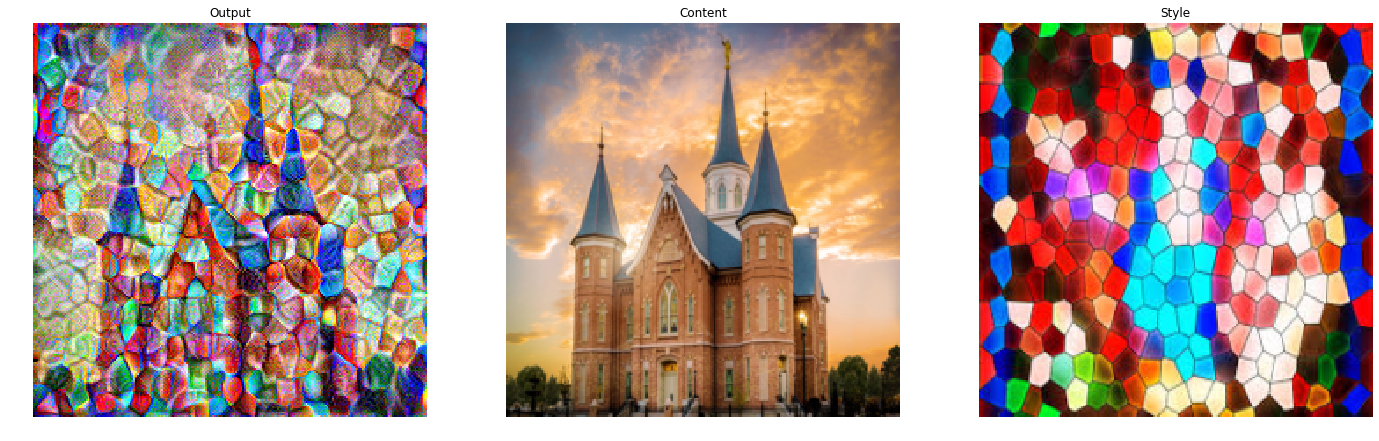

In [348]:
EPOCHS = 200
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 5000

# Start with a copy of the content image
output_image = content_image.clone()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 

optimizer = optim.Adam([output_image.requires_grad_()], lr=0.1)

for epoch in range(EPOCHS):
  optimizer.zero_grad()
  output_image.data.clamp_(0, 1)
  vgg_out = vgg(output_image)
  
  content_loss = 0
  for layer in content_indeces:
    content_loss += content_modules[layer](vgg_out[layer])

  style_loss = 0
  for layer in style_indeces:
    style_loss += style_modules[layer](vgg_out[layer])
    
  style_loss *= STYLE_WEIGHT
  content_loss *= CONTENT_WEIGHT
  
  loss = style_loss + content_loss
  loss.backward()
  optimizer.step()
  
  if epoch % 50 == 0:
    print("epoch {}:".format(epoch))
    print("Style Loss: {:4f} Content Loss: {:4f}".format(style_loss.item(), content_loss.item()))

# Show the image
output_image.data.clamp_(0, 1)
imshow([output_image, content_image, style_image], title=['Output', 'Content', 'Style'])

### Part 5

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**Equation 1:**

This equation computes the error loss between the original image and generated image. It is very similar to the mean squared error loss function. Essentially we are taking the difference between the two feature maps (for each layer) and squaring the result. This value is then summed over the number of layers and divided by two.

Lcontent: the error between the original image and the generated image

p: the original image

x: the generated image

l: the lth layer

F: the generated image's feature maps

P: the orignal image's feature maps


**Equation 3:**

This equation computes the Gram Matrix. The Gram Matrix is achieved by taking the inner product of a given feature map.

G: the gram matrix

F: the feature map

i: the ith filter

l: the lth layer

k: the position

**Equation 4:**

This equations calculates the total loss for a given layer. It compares the loss between the generated image and the gram matrix of the original image.

Et: the total loss attributed to a given layer

Al: the original image's feature maps

Gl: the generated image's feature maps

N,M: the dimensions

**Equation 5:**

This equation seeks to compute the total style loss over all layers. You multiply the weight given to style by the total loss of the layer of a given layer. This value is then summed across all layers to give a total style loss value.

a: original image

x: generated image

L-style: total style loss over all layers

wt: the weight given to style

Et: the total loss attributed to a given layer
